In [2]:
source("../R/eval.R")
library(ggplot2)
library(scales)
library(dplyr)
library(patchwork)

In [1]:
get_ct_count <- function(ffpe_annot, ff_annot, dataset_id, match_id_col, sample_id_col = "sample_name") {
	
	ct_count <- list()

	for (i in seq_len(nrow(ffpe_annot))){
		
		sample_number <- ffpe_annot[i, match_id_col]
		ffpe_sample_name <- ffpe_annot[i, sample_id_col]

		message(sprintf("processing %s. %s", i, ffpe_sample_name))

		matched_ff_annot <- ff_annot[ff_annot[[match_id_col]] == sample_number, ]
		ff_sample_name <- matched_ff_annot[[sample_id_col]]
		
		ffpe_snv <- read_vcf(file.path(vcf_dir, ffpe_sample_name, sprintf("%s.vcf", ffpe_sample_name)), columns = c("chrom", "pos", "ref", "alt"))
		# Filter C:G>T:A variants
		ffpe_snv_ct <- ct_filter(ffpe_snv)

		ff_snv <- read_vcf(file.path(vcf_dir, ff_sample_name, sprintf("%s.vcf", ff_sample_name)), columns = c("chrom", "pos", "ref", "alt"))
		# Filter C:G>T:A variants
		ff_snv_ct <- ct_filter(ff_snv)

		## Count C>T variants
		n_ct_ffpe <- nrow(ffpe_snv_ct)
		n_ct_ff <- nrow(ff_snv_ct)

		sample_ct_count <- data.frame(
			ffpe_sample_name = ffpe_sample_name,
			matched_ff_sample_name = ff_sample_name,
			n_ct_ffpe = n_ct_ffpe,
			n_ct_ff = n_ct_ff
		)

		ct_count[[i]] <- sample_ct_count

	}

	all_ct_count <- do.call(rbind, ct_count)
	## Wide to Long
	ct_count_long <- reshape(all_ct_count, idvar = c("ffpe_sample_name", "matched_ff_sample_name"), direction = "long", v.names = "n_ct", varying = c("n_ct_ffpe", "n_ct_ff"), timevar = "sample_type", times = c("FFPE", "Fresh Frozen"))
	row.names(ct_count_long) <- NULL
	ct_count_long$dataset_id <- dataset_id

	ct_count_long
}


In [2]:
make_bar_chart <- function(df){
	ggplot(data = df, aes(x = ffpe_sample_name, y = n_ct, fill = sample_type)) +
	facet_wrap(~dataset_id, scales = "free") +
	geom_bar(stat="identity", position=position_dodge()) +
	scale_y_continuous(labels = label_number()) +
	labs(
		x = "Samples", 
		y = "C>T Mutation Count",
		# fill = "Sample Type",
		# title = "C:G>T:A SNV Count"
	) +
	# theme_minimal() +
	theme(
		plot.title = element_text(hjust = 0.5, face = "bold", size = 12, margin = margin(t = 10, b = 10)),
		plot.subtitle = element_text(hjust = 0.5),
		plot.caption = element_text(hjust = 0),
		legend.position = "bottom",
		legend.title = element_blank(), # element_text(size = 10)
		legend.text = element_text(size = 8),
		legend.key.size = unit(0.5, "cm"),
		axis.text.x = element_blank(),
		axis.ticks.x = element_blank(),
		panel.background = element_rect(fill = "white", color = NA)
		# axis.title.x = element_text(size = 10),
		# axis.title.y = element_text(size = 10),
		
	)
}

In [40]:

w= 8; h = 5
options(repr.plot.width = w, repr.plot.height = h)

## Dot Plots

In [3]:
betge_ct_plot <- readRDS("ena_PRJEB8754/PRJEB8754_ct_count_dot_plot.rds")
bonnet_ct_count <- readRDS("ega_EGAD00001004066/EGAD00001004066_ct_count_dot_plot.rds")
srp_ct_plot <- readRDS("ena_SRP044740/SRP044740_ct_count_dot_plot.rds")
tcga_plot <- readRDS("tcga/tcga_ct_count_dot_plot.rds")

In [10]:
count_path <- Sys.glob("*/*_ct_count.tsv")

all_dset_ct_count <- do.call(
	rbind,
	lapply(count_path, read.delim)
)

# all_dset_ct_count <- all_dset_ct_count[all_dset_ct_count$dataset_id != "TCGA",]
case_counts <- all_dset_ct_count |>
	group_by(dataset_id) |>
	summarise(n_samples = n_distinct(case_id))



In [15]:
for (i in seq_len(length(case_counts$n_samples))){
	if (case_counts$n_samples[i] < 4) {
		case_counts$n_samples[i] <- 4
	} 
}

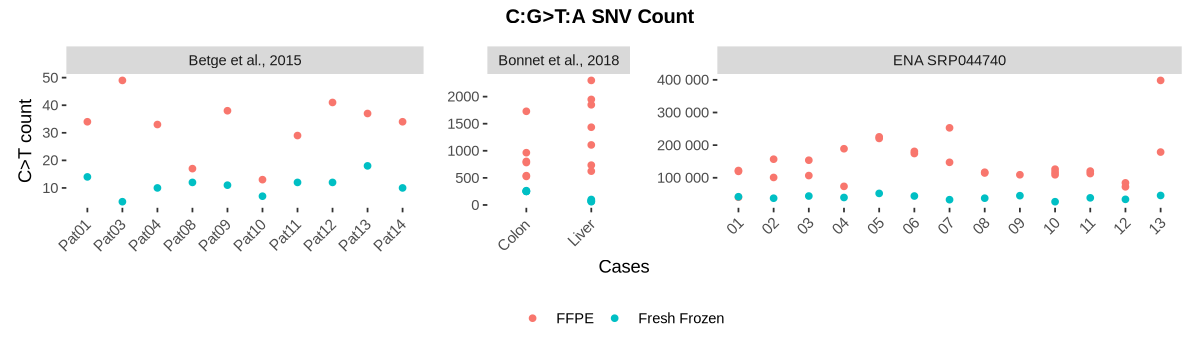

In [16]:

final_plot <- (betge_ct_plot + bonnet_ct_count + srp_ct_plot) +
	plot_layout(
			# widths applies to the columns defined by the top row.
			# tcga_plot will automatically span the full width of the row below.
			widths = case_counts$n_samples[1:3],
			guides = "collect", # Collect all legends into a single common legend
			axis_titles = "collect", # Collect common axis titles
	) +
	plot_annotation(
		title = "C:G>T:A SNV Count",
		theme = theme(
			plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
			plot.caption = element_text(hjust = 0.5, size = 11),
			legend.position = "bottom",
			legend.title = element_blank()
		)
	)

options(repr.plot.width = 10, repr.plot.height = 3)
qdraw(final_plot, "aggregated_ct_plot-without_tcga.pdf", width = 10, height = 3)
final_plot

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 8)

final_plot <- final_plot + plot_layout(guides = "auto")
final_plot_with_tcga <- (final_plot / tcga_plot) +
	plot_layout(
				guides = "collect", # Collect all legends into a single common legend
				axis_titles = "collect", # Collect common axis titles
				heights = c(2, 3)
		) +
	plot_annotation(
		title = "C:G>T:A SNV Count",
		theme = theme(
			plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
			plot.caption = element_text(hjust = 0.5, size = 11),
			legend.position = "bottom",
			legend.title = element_blank(),
		)
	)

qdraw(final_plot_with_tcga, "aggregated_ct_plot-with_tcga.pdf", width = 10, height = 5)
final_plot_with_tcga

ERROR: [1m[33mError[39m in `plot_layout()`:[22m
[1m[22m[33m![39m `guides` must be one of "auto", "collect", or "keep", not "Collect".
[36mℹ[39m Did you mean "collect"?
